## Dangerous Accessible Space / Physical pass simulation

This tutorial shows you how to calculate an <b>Expected Pass Completion</b> rate (risk of a pass) and a quantity called <b>Dangerous accessible space (DAS)</b> (which corresponds to the value of a situation) using a <b>physical simulation</b> of the ball and player kinematics. The model is due to Bischofberger & Baca (2025), building on the well-known physical pass simulation model by Spearman et al. (2017).

Generally speaking, we know that physical models tend to perform worse on predicting pass success than machine learning models (Bischofberger & Baca, 2025), so why should you bother performing tedious simulations when you could just throw a neural network at the problem and be seemingly better off? The key advantage is that the <b>physical simulation contains additional knowledge about how a pass works</b>. For example, the simulation model understands that as soon as a pass has been intercepted by a player it cannot be intercepted a second time further down the trajectory. Its additional knowledge about passing mechanics allows a phyiscal model to better generalize towards hypothetical passes than data-driven approaches like machine learning. Data-driven models learn exclusively from actually occurring passes, so if you extrapolate your machine learning model to predict some hypothetical pass towards a random location on the pitch, how can you expect your result to be accurate? That is where physical models come into play: They are not just grounded in data but also in theory. So they do not have a strong bias towards actually occurring passes but make reasonable predictions for any pass that you give it.

Once we have a model that generalizes well towards any pass, we can apply it to many passes across the entire pitch. That way, we obtain a valid <b>pass completion surface</b> which shows you which spaces on the pitch are accessible or inaccessible through as pass. Using this surface, you can visualize, reason about and quantify offensive space occupation, defensive space control and evaluate various aspects of decision-making on an individual and collective level.

Let's dive into it.


### 1. Preparations

We use pandas, numpy and scipy for calculating the model, and matplotlib and databallpy for visualization.

In [9]:
import collections
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate

import databallpy.visualize

First, we prepare a dummy frame of tracking data which we will use to simulate a single pass.

In [10]:
# Tracking data
df = pd.DataFrame({
    "frame_id": [0, 0, 0, 0, 0],
    "player": ["a", "x", "b", "y"] + ["ball"],
    "x": [-1, 10, 20, 50] + [0],
    "y": [0, 5, 27.5, -20] + [0],
    "vx": [0, 2, 0, 0] + [0],
    "vy": [0, 0, 0, 0] + [0],
    "team": ["H", "A", "H", "A"] + ["ball"],
    "player_color": ["blue", "orange", "red", "green", "black"],
    "team_in_possession": ["H", "H", "H", "H", "H"],
})
players = df["player"][:-1].values
players_x = df["x"][:-1].values
players_y = df["y"][:-1].values
players_vx = df["vx"][:-1].values
players_vy = df["vy"][:-1].values
teams = df["team"][:-1].values
passer = "a"  # player index of the passer
passer_team = teams[players == passer][0]
player_colors = df["player_color"][:-1].values
ball_x0 = df["x"].iloc[-1]
ball_y0 = df["y"].iloc[-1]

# Parameters of the pass to be simulated
pass_speed = 15
pass_angle = math.pi/4

# Some namedtuples to access matplotlib plots nicely
FigAx = collections.namedtuple("FigAx", ["fig", "ax"])
Figs = collections.namedtuple("Figs", ["plot3d", "plot2d"])

df

,frame_id,player,x,y,vx,vy,team,player_color,team_in_possession
0,0,a,-1,0.0,0,0,H,blue,H
1,0,x,10,5.0,2,0,A,orange,H
2,0,b,20,27.5,0,0,H,red,H
3,0,y,50,-20.0,0,0,A,green,H
4,0,ball,0,0.0,0,0,ball,black,H


Next, we define some functions to visualize our data. One of these is will create a 3D plot that will help us later to visualize various quantities as they evolve along the trajectory of the pass. The other one uses ```databallpy```'s ```visualize``` module to create a 2D plot.

In [11]:
def plot_constellation_2d():
    plt.figure()
    databallpy.visualize.plot_soccer_pitch()
    for team in np.unique(teams):
        color = {"H": "blue", "A": "red"}[team]
        team_players_x = players_x[teams == team]
        team_players_y = players_y[teams == team]
        plt.scatter(team_players_x, team_players_y, label=f"{team} Players", color=color, s=150)

        team_players_vx = players_vx[teams == team]
        team_players_vy = players_vy[teams == team]
        for x, y, vx, vy in zip(team_players_x, team_players_y, team_players_vx, team_players_vy):
            if vx == 0 and vy == 0:
                continue
            plt.arrow(x, y, vx, vy, head_width=1, head_length=1, fc=color, ec=color)

        # plot player names
        for i, player in enumerate(players):
            if teams[i] != team:
                continue
            plt.text(players_x[i], players_y[i]-2, player, fontsize=20, ha="center", va="top", color=color, weight="bold")

    plt.scatter(ball_x0, ball_y0-0.5, label="Ball", color="black", s=500, marker="x", linewidths=4)


def three_d_plot(name_minus_z=-0.75):
    ax = plt.axes(projection='3d')
    ax.set_zlim(0, 1)

    # draw pitch
    ax.plot([-52.5, -52.5], [-34, 34], [0, 0], color="grey")
    ax.plot([52.5, 52.5], [-34, 34], [0, 0], color="grey")
    ax.plot([-52.5, 52.5], [-34, -34], [0, 0], color="grey")
    ax.plot([-52.5, 52.5], [34, 34], [0, 0], color="grey")

    # middle line
    ax.plot([0, 0], [-34, 34], [0, 0], color="grey")

    # middle circle
    theta = np.linspace(0, 2 * np.pi, 100)
    x = 9 * np.cos(theta)
    y = 9 * np.sin(theta)
    ax.plot(x, y, 0, color="grey")

    # Penalty box
    ax.plot([-52.5, -52.5+16.5], [-16.5-7.32/2, -16.5-7.32/2], [0, 0], color="grey")
    ax.plot([-52.5, -52.5+16.5], [16.5+7.32/2, 16.5+7.32/2], [0, 0], color="grey")
    ax.plot([-52.5+16.5, -52.5+16.5], [-16.5-7.32/2, 16.5+7.32/2], [0, 0], color="grey")
    ax.plot([-52.5+16.5, -52.5+16.5], [16.5+7.32/2, -16.5-7.32/2], [0, 0], color="grey")

    # Other penalty box
    ax.plot([52.5, 52.5-16.5], [-16.5-7.32/2, -16.5-7.32/2], [0, 0], color="grey")
    ax.plot([52.5, 52.5-16.5], [16.5+7.32/2, 16.5+7.32/2], [0, 0], color="grey")
    ax.plot([52.5-16.5, 52.5-16.5], [-16.5-7.32/2, 16.5+7.32/2], [0, 0], color="grey")
    ax.plot([52.5-16.5, 52.5-16.5], [16.5+7.32/2, -16.5-7.32/2], [0, 0], color="grey")

    # give z axis independent aspect
    ax.set_box_aspect([52.5*2, 34*2, 100])

    for player in players:
        player_index = np.where(players == player)[0][0]
        player_color = player_colors[player_index]
        ax.scatter(players_x[player_index], players_y[player_index], 0, color=player_color, alpha=1)
        ax.text(players_x[player_index], players_y[player_index], name_minus_z, player, color=player_color, fontsize=12, ha="center", va="center")

    return ax

Let's finish our preparations by having a look at our dummy data.

<Figure size 640x480 with 0 Axes>

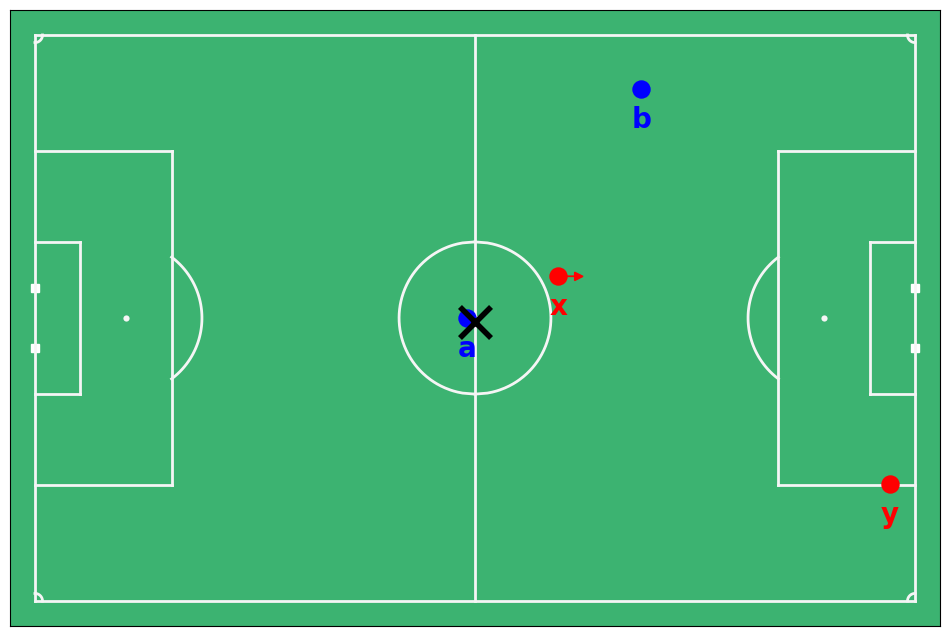

In [13]:
plot_constellation_2d()

### Calculating the model

#### Step 1: Ball trajectory

In the first step, we simulate the motion of the ball during the pass. We only simulate the 2D position, ignoring the z-coordinate.

We start by calculating a spatial 1D grid (```D_BALL_SIM```) for the pass using a constant grid size. The longest possible pass would cover the entire diagonal of the pitch, i.e. sqrt(105**2 + 68**2) = around 125 meters. To be safe about covering the entire playable area with our simulation, we choose to simulate up to a distance of 150 meters.

After that, we convert ```D_BALL_SIM``` into x and y coordinates, obtaining ```X_BALL_SIM``` and ```Y_BALL_SIM```.

TODO: exponents/math in Readme

D_BALL_SIM (61,)
[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100.  102.5 105.  107.5 110.  112.5 115.  117.5
 120.  122.5 125.  127.5 130.  132.5 135.  137.5 140.  142.5 145.  147.5
 150. ]


<Figure size 640x480 with 0 Axes>

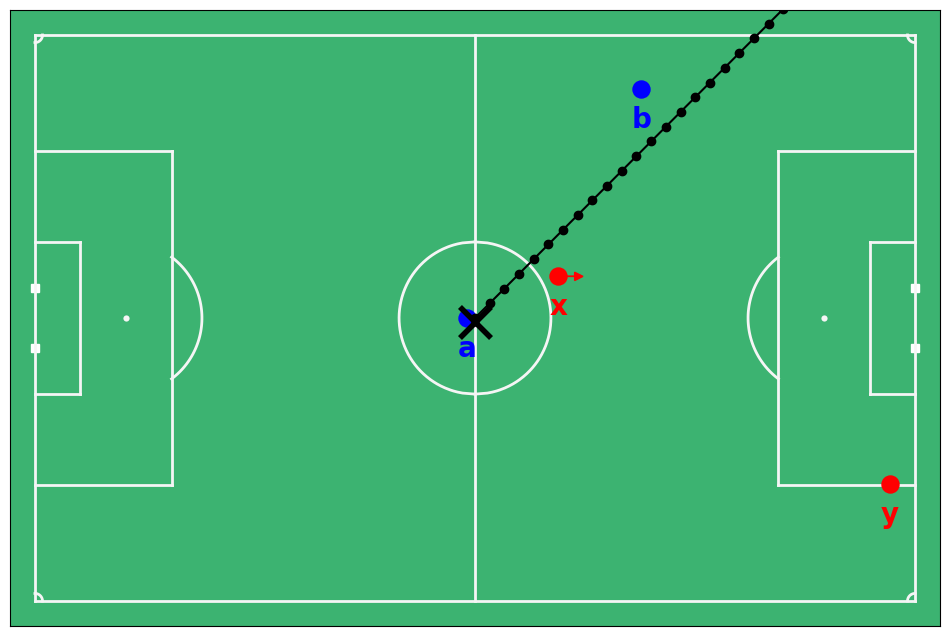

In [11]:
radial_gridsize = 2.5
max_pass_length = 150
D_BALL_SIM = np.arange(0, max_pass_length + radial_gridsize, radial_gridsize)  # T
print("D_BALL_SIM", D_BALL_SIM.shape)
print(D_BALL_SIM)

X_BALL_SIM = ball_x0 + math.cos(pass_angle) * D_BALL_SIM  # T
Y_BALL_SIM = ball_y0 + math.cos(pass_angle) * D_BALL_SIM  # T

### Plotting
plot_constellation_2d()
plt.plot(X_BALL_SIM, Y_BALL_SIM, "-o", label="Ball trajectory", color="black")
plt.show()

Since our physical simulation model treats the pass as a temporal process, we need to transform the spatial grid into a temporal grid using a kinematic motion model for the ball. In this case, we choose to model it using constant speed, which simplifies our calculations and is usually a good enough approximation of real-world ball kinematics.

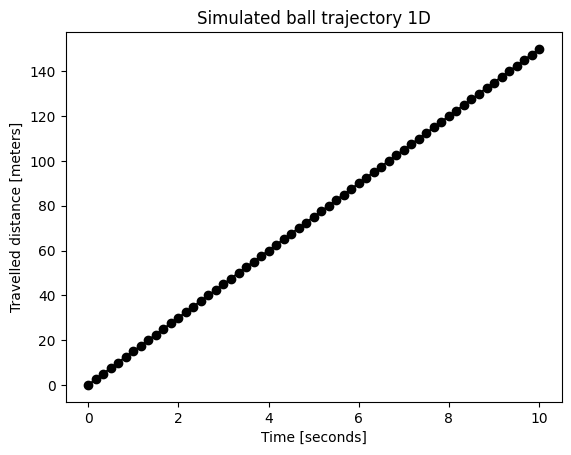

In [12]:
def time_to_arrive_1d(x, v, x_target):  # Function to calculate the time to go from x to x_target (with speed 'v')
    return (x_target - x) / v

T_BALL_SIM = time_to_arrive_1d(x=D_BALL_SIM[0], v=pass_speed, x_target=D_BALL_SIM)  # T

### Plotting
plt.plot(T_BALL_SIM, D_BALL_SIM, "-o", color="black")
plt.title("Simulated ball trajectory 1D")
plt.xlabel("Time [seconds]")
plt.ylabel("Travelled distance [meters]")
plt.show()

#### Step 2: Players' time to arrive

To obtain interception probabilities along our predicted ball trajectory, we estimate the fastest possible arrival times of all players at all points along the ball's trajectory.

The basic idea for obtaining arrival times is to decompose player movement into two segments of constant velocity. The first segment is in the direction of the current motion and retains the player's speed while the second one is directed towards the target location with a fixed speed. This is the basic version of a model that has been shown to be effective in pinning down the reachable areas of players (Renkin, Bischofberger, Schikuta & Baca, 2022) while remaining computationally efficient.

C:\Users\Jonas\AppData\Local\pypoetry\Cache\virtualenvs\databallpy-lb8o37yy-py3.10\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:177: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


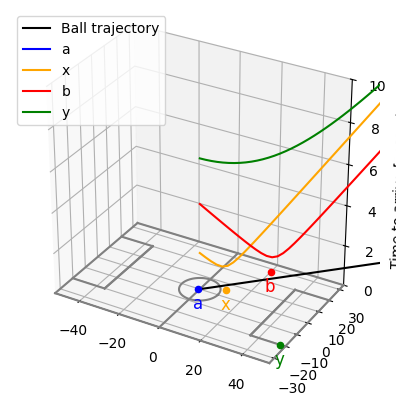

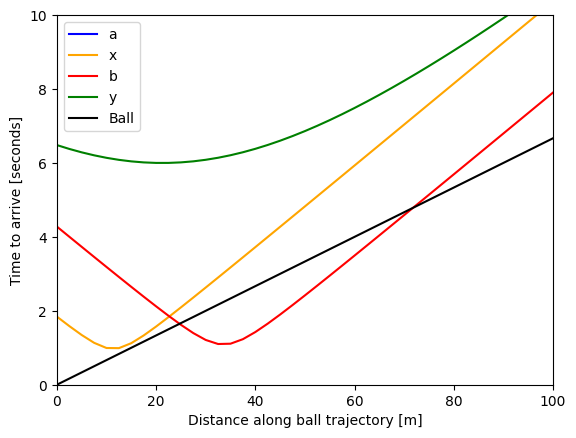

In [13]:
def approx_two_point_time_to_arrive(x, y, vx, vy, x_target, y_target, speed_segment2=9, inertial_seconds=0.5):
    x_mid, y_mid = x + vx * inertial_seconds, y + vy * inertial_seconds
    time_segment2 = np.sqrt((x_target - x_mid) ** 2 + (y_target - y_mid) ** 2) / speed_segment2
    return inertial_seconds + time_segment2

TTA_PLAYERS = approx_two_point_time_to_arrive(
    x=players_x[:, np.newaxis], y=players_y[:, np.newaxis], vx=players_vx[:, np.newaxis], vy=players_vy[:, np.newaxis],
    x_target=X_BALL_SIM[np.newaxis, :], y_target=Y_BALL_SIM[np.newaxis, :],
)  # P x T
# Our data has become 2-dimensional now, since we simulate arrival times of all players (dimension 1) along all points of the trajectory (dimension 2). To keep track of them, we indicate the dimensions of our numpy arrays with the following captial letters: P = players, T = simulation time.

# We exclude the passer by setting their arrival time to infinity. This is because a pass cannot be received by the passer him- or herself by definition.
TTA_PLAYERS[players == passer] = np.inf

# We use another helper function to plot our data both in 2D and 3D
def double_plot(data, z_label="", data_names=None, dz=-0.75):
    plt.figure()
    figs = []
    ax = three_d_plot(dz)

    # Draw ball trajectory
    ax.plot(X_BALL_SIM, Y_BALL_SIM, 0, "-", label="Ball trajectory", color="black")
    ax.set_zlim(0, 10)
    ax.set_xlim(-52.5, 52.5)
    ax.set_ylim(-34, 34)

    if isinstance(data, list):
        for i, y in enumerate(data):
            ax.plot(X_BALL_SIM, Y_BALL_SIM, y, "-", label=data_names[i])

    elif len(data.shape) == 2:  # P x T
        for player in players:
            player_index = np.where(players == player)[0][0]
            ax.plot(X_BALL_SIM, Y_BALL_SIM, data[player_index, :], "-", color=player_colors[player_index], label=player)

    ax.set_zlabel(z_label)
    figs.append(FigAx(plt.gcf(), plt.gca()))
    plt.legend()

    plt.figure()
    ax = plt.gca()
    if isinstance(data, list):
        for i, y in enumerate(data):
            ax.plot(D_BALL_SIM, y, "-", label=data_names[i])
    elif len(data.shape) == 2:
        for player in players:
            player_index = np.where(players == player)[0][0]
            ax.plot(D_BALL_SIM, data[player_index], "-", color=player_colors[player_index], label=player)
    plt.ylabel(z_label)
    figs.append(FigAx(plt.gcf(), plt.gca()))
    plt.legend()

    return Figs(plot3d=figs[0], plot2d=figs[1])
    # return figs

### Plotting
figs = double_plot(TTA_PLAYERS, "Time to arrive [seconds]")
figs.plot2d.ax.plot(D_BALL_SIM, T_BALL_SIM, "-", color="black", label="Ball")
plt.xlim((0, 100))
plt.ylim((0, 10))
plt.xlabel("Distance along ball trajectory [m]")
plt.legend()
plt.show()

We see that player "x" has a lower arrival time between around 25m and 70m of travel distance of the pass, so "x" can intercept the ball comfortably during segment. However, player "b" gets close to the ball after around 10 meters, so he or she might be able to intercept the ball before "x". Player "y" never arrives earlier at a location than the ball and therefore only has minor chances to intercept the pass. Player "a" is the passer and therefore excluded from interception.

#### 3. Transform arrival times into interception rates

Transforming arrival times into interception rates is performed using a sigmoid function on the difference between the arrivale times of each player and the ball. The earlier you arrive before the ball, the higher your rate of interception.

The actual implementation of the model uses an approximate version of the sigmoid function that speeds it up significantly. Calculating interception rates of many players among many points along many trajectories in many frames of a football game is a very high-dimensional and expensive task, therefore it is important to make this step as efficient as possible.

We can examine the quality of the approximation visually, finding that the approximation gives us the S-shape we want while deviating from the classic sigmoid. For the rest of this tutorial, we use the exact sigmoid, but feel free to try out the approximation and see how the results change!

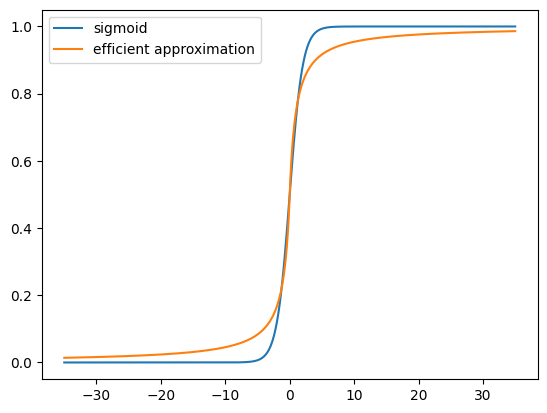

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def efficient_sigmoid(x):  # Computationally efficient approximation
    return 0.5 * (x / (1 + np.abs(x)) + 1)

x = np.linspace(-35, 35, 1000)
y = sigmoid(x)
y_approx = efficient_sigmoid(x)

plt.plot(x, y, label="sigmoid")
plt.plot(x, y_approx, label="efficient approximation")
plt.legend()
plt.show()

Now we are ready to calculate the intereption rates. Inserting the time difference into our sigmoid function introduces two parameters, b0 and b1. b0 is related to your likeliness to be able to intercept when you arrive at the same time as the ball while b1 is related to the rate at which the interception rate increases and decreases with earlier and later arrival times.

DT 0.16666666666666666


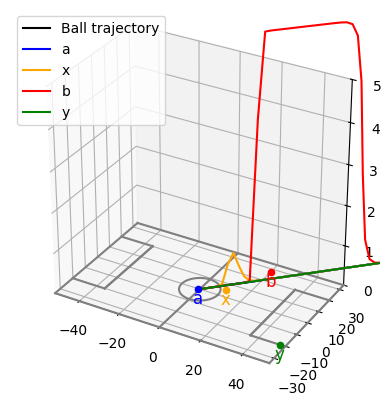

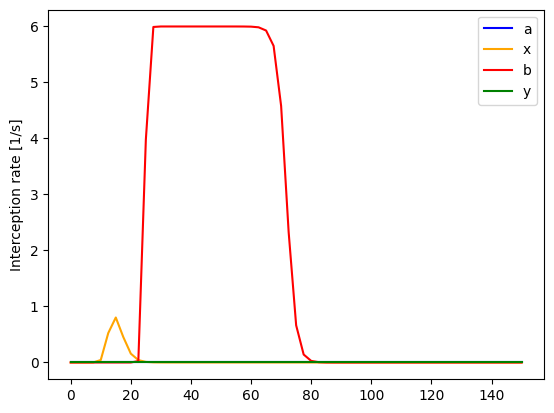

In [9]:
b0 = 0
b1 = -15

# Feel free to try out "efficient_sigmoid" here.
simulated_probability = sigmoid(b0 + b1 * (TTA_PLAYERS - T_BALL_SIM[np.newaxis, :]))  # P x T, TODO check plus minus
simulated_probability = np.nan_to_num(simulated_probability, nan=0)  # P x T
DT = T_BALL_SIM[1] - T_BALL_SIM[0]  # This only works because we use constant speed for the ball trajectory
print("DT", DT)
interception_rate = simulated_probability / DT  # P x T

figs = double_plot(interception_rate, "Interception rate [1/s]", dz=-0.25)
figs.plot3d.ax.set_zlim(0, 5)
plt.show()

We see that Player x's earlier pre-ball arrival between 25 and 70 meters translates into a high interception rate close to the maximum interception rate. Player b also has a small peak with an interception rate of up to 1s<sup>-1</sup>.

Given our gridsize of 2.5 meters and simulated ball speed of 15 meters per second, the highest possible interception rate is 1 / DT = 1 / (DX / v_ball) = 1 / (5/15) = 1/(1/3) = 6 s<sup>-1</sup>.

#### 3. Use interception rates to calculate probabilities

The next step is the most mathematically complicated.

[TODO]

We start with calculating the probability P0 that no player can intercept the pass. This sum is related to the sum of the interception rates of all players.

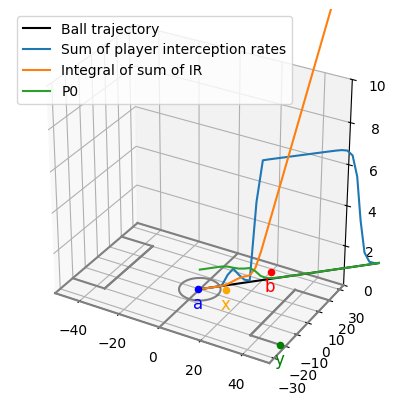

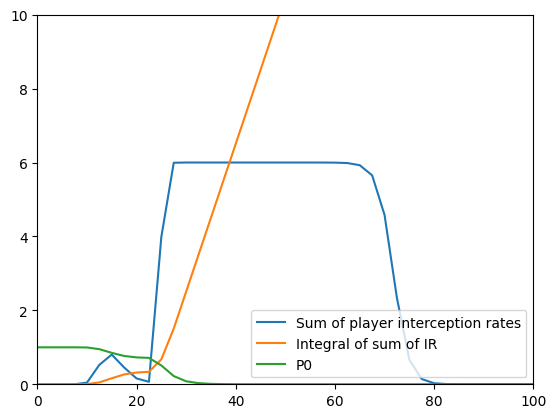

In [10]:
sum_ar = np.nansum(interception_rate, axis=0)  # T
int_sum_ar = scipy.integrate.cumulative_trapezoid(y=sum_ar, x=T_BALL_SIM, initial=0, axis=-1)
p0_cum = np.exp(-int_sum_ar)

figs = double_plot([sum_ar, int_sum_ar, p0_cum], "", data_names=["Sum of player interception rates", "Integral of sum of IR", "P0"])
figs[1].ax.set_ylim([0, 10])
figs[1].ax.set_xlim([0, 100])
plt.show()

You see that the probability that no one intercepts starts at 1, where exp ... blabla

Using the cumulative P0, we can compute the individual probability densities.

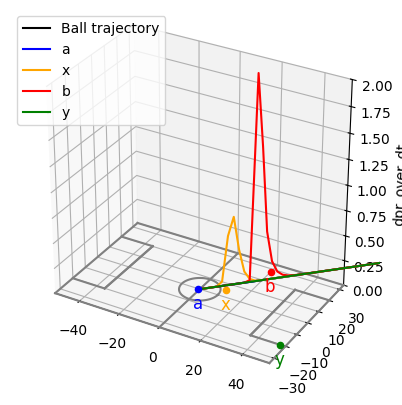

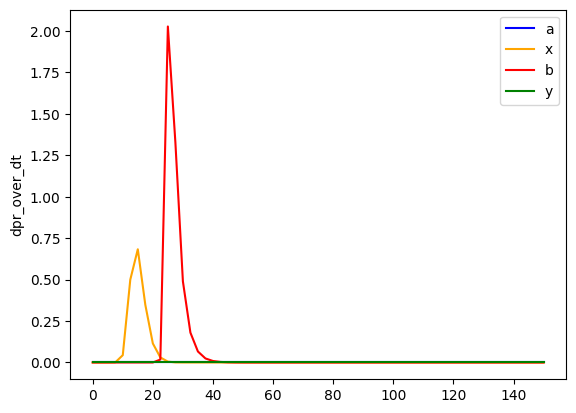

In [11]:
dpr_over_dt = p0_cum[np.newaxis, :] * interception_rate  # P x T
dpr_over_dt = np.nan_to_num(dpr_over_dt, nan=0)  # P x T

### Plotting
figs = double_plot(dpr_over_dt, "dpr_over_dt", dz=-0.15)
figs.plot3d.ax.set_zlim([0, 2])
plt.legend()
plt.show()

Now we see X.

Let's make another plot for only one player to see the relationship between interception rate, interception probability density and the cumulative probability P0.

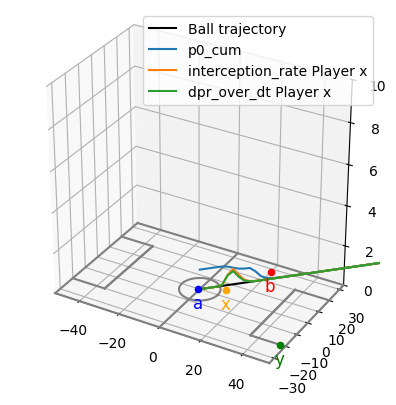

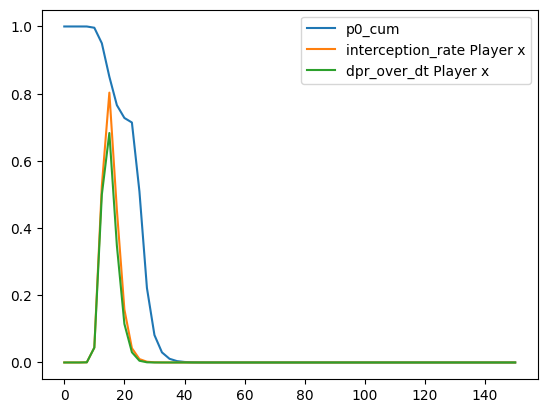

In [12]:
player_to_plot = "x"
i_player_to_plot = (players == player_to_plot)

double_plot([p0_cum, interception_rate[i_player_to_plot, :][0], dpr_over_dt[i_player_to_plot, :][0]], "", ["p0_cum", f"interception_rate Player {player_to_plot}", f"dpr_over_dt Player {player_to_plot}"])
plt.legend()
plt.show()

Using the individual probability densities, we can easily obtain cumulative probabilities by integration.

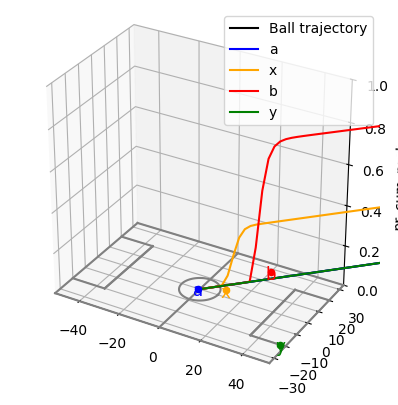

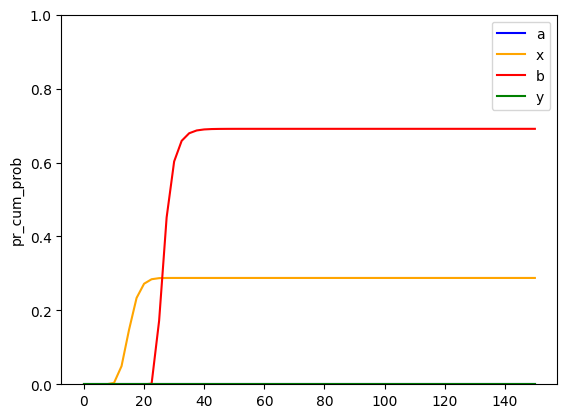

In [13]:
pr_cum_prob = scipy.integrate.cumulative_trapezoid(y=dpr_over_dt, x=T_BALL_SIM, initial=0, axis=-1)
figs = double_plot(pr_cum_prob, "pr_cum_prob", dz=-0.01)
figs[0].ax.set_zlim([0, 1])
figs[1].ax.set_ylim([0, 1])
plt.show()

In order to use our simulated probability densities in a spatial context, we need to transform them from time to space.

In [14]:
DX = radial_gridsize  # works because we have a uniform grid
dpr_over_dx = dpr_over_dt * DT / DX

The final step is to transform the probabilities and densities from the player level to the team level by aggregating over all members of each team (attacking and defending team).

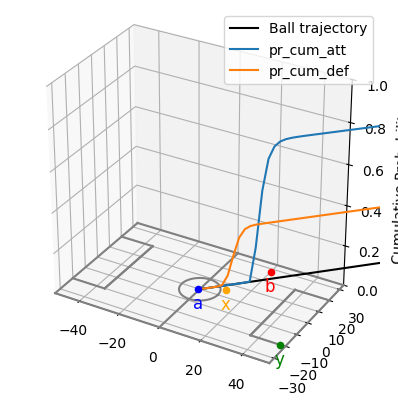

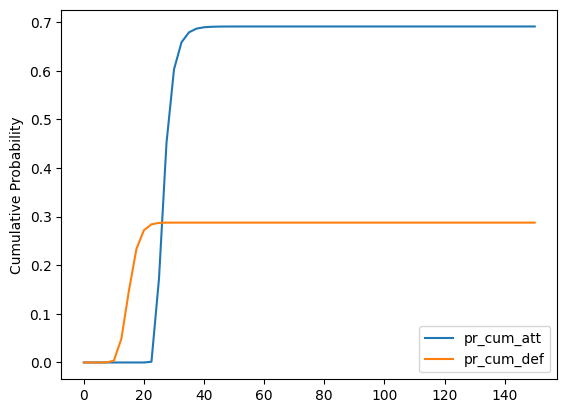

In [15]:
player_is_attacking = passer_team == teams  # P

dpr_over_dx_att = np.nansum(np.where(player_is_attacking[:, np.newaxis], dpr_over_dx, 0), axis=0)
dpr_over_dx_def = np.nansum(np.where(~player_is_attacking[:, np.newaxis], dpr_over_dx, 0), axis=0)
# dp0_over_dt = -p0_cum * sum_ar  # F x V0 x PHI x T
# dp0_over_dx = dp0_over_dt * DT / DX

pr_cum_att = np.nansum(np.where(player_is_attacking[:, np.newaxis], pr_cum_prob, 0), axis=0)
pr_cum_def = np.nansum(np.where(~player_is_attacking[:, np.newaxis], pr_cum_prob, 0), axis=0)

figs = double_plot([pr_cum_att, pr_cum_def], "Cumulative Probability", ["pr_cum_att", "pr_cum_def"], dz=-0.075)
figs.plot3d.ax.set_zlim([0, 1])
plt.show()

We are done! The last value of the cumulative interception probability of the attacking team is the Expected Completion (xC) rate of the pass.

If we want, we can also calculate the location of the most likely interception, per player, per team or in general. In this example, we calculate the most likely location of interception per player.

Expected completion: 69.1%
Expected interception: 28.8%
Expected out: 0.0%


<Figure size 640x480 with 0 Axes>

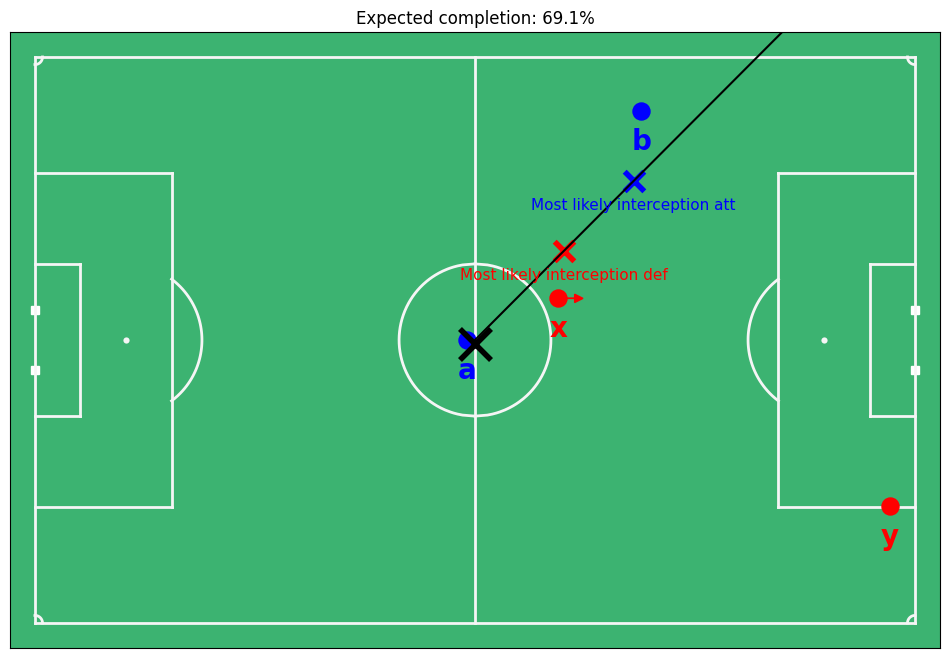

In [16]:
xc = pr_cum_att[-1]

print(f"Expected completion: {xc:.1%}")
print(f"Expected interception: {pr_cum_def[-1]:.1%}")
print(f"Expected out: {p0_cum[-1]:.1%}")

# Predict the most likely interception location on the team-level
team_to_most_likely_interception_location = {}
for team, dpr in [("att", dpr_over_dx_att), ("def", dpr_over_dx_def)]:
    mean_distance = np.sum(dpr * D_BALL_SIM) / np.sum(dpr)
    most_likely_interception_x = ball_x0 + math.cos(pass_angle) * mean_distance
    most_likely_interception_y = ball_y0 + math.sin(pass_angle) * mean_distance
    team_to_most_likely_interception_location[team] = (most_likely_interception_x, most_likely_interception_y)

### Plotting
plot_constellation_2d()
plt.plot(X_BALL_SIM, Y_BALL_SIM, "-", label="Ball trajectory", color="black")
for team, (x, y) in team_to_most_likely_interception_location.items():
    plt.scatter(x, y, label=f"Most likely interception {team}", color={"att": "blue", "def": "red"}[team], s=200, marker="x", linewidths=4)
    plt.text(x, y-2, f"Most likely interception {team}", fontsize=11, ha="center", va="top", color={"att": "blue", "def": "red"}[team])

plt.title(f"Expected completion: {xc:.1%}")
plt.show()

### Dangerous accessible space

In order to calculate the DAS, we simulate passes with different angles (and speeds if we want) and spatially aggregate the result into a surface that spans the entire pitch.

An important caveat in this step is that compared to expected completion, we don't care anymore about the [i]probability[/i] that a pass is intercepted somewhere. We care about all the locations where a pass is [i]possible[/i]. This is an important difference that affects how the interception rates are processed. The basic idea is that the interception rates of your own teammates don't affect your possibility to intercept as they can just let the ball roll instead of eagerly intercepting it. Therefore, we split the interception rates by team and use only the interception rates of the opponent team to calculate the possibility density.

This is how it works:

dpr_poss_over_dt (4, 61)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.95583034e-12 3.36089998

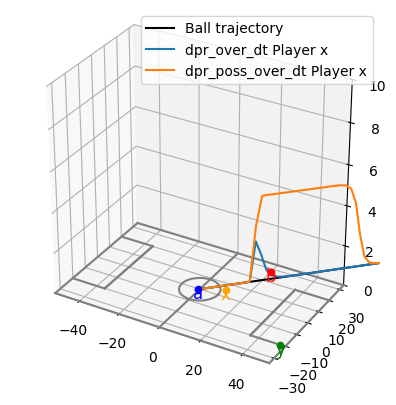

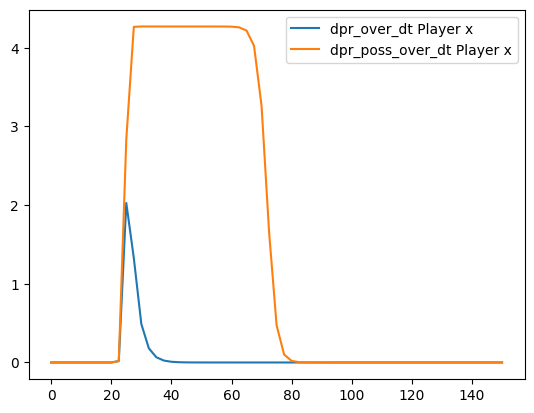

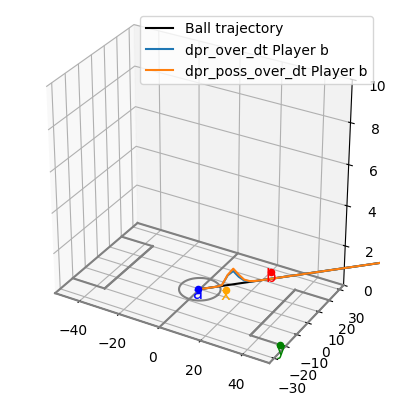

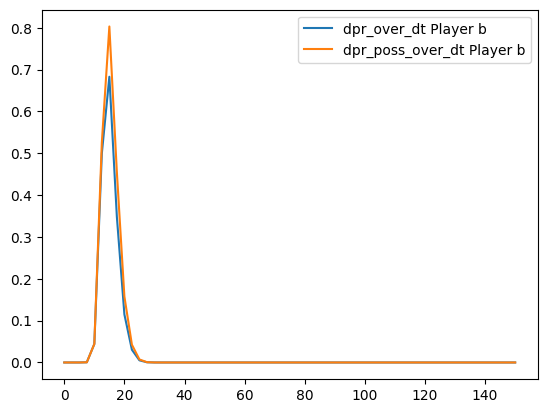

In [17]:
sum_ar_att = np.nansum(np.where(player_is_attacking[:, np.newaxis], interception_rate, 0), axis=0)  # T
sum_ar_def = np.nansum(np.where(~player_is_attacking[:, np.newaxis], interception_rate, 0), axis=0)  # T
int_sum_ar_att = scipy.integrate.cumulative_trapezoid(y=sum_ar_att, x=T_BALL_SIM, initial=0, axis=-1)  # T
int_sum_ar_def = scipy.integrate.cumulative_trapezoid(y=sum_ar_def, x=T_BALL_SIM, initial=0, axis=-1)  # T
p0_cum_only_att = np.exp(-int_sum_ar_att)  # T
p0_cum_only_def = np.exp(-int_sum_ar_def)  # T
p0_only_opp = np.where(  # P x T, a version of P0 that only gets decreased by the interception rates of the opponent team of the respective player.
    player_is_attacking[:, np.newaxis],
    p0_cum_only_def[np.newaxis, :], p0_cum_only_att[np.newaxis, :]
)
dpr_poss_over_dt = p0_only_opp * interception_rate  # P x T

print("dpr_poss_over_dt", dpr_poss_over_dt.shape)
print(dpr_poss_over_dt)

### Plotting
figs = double_plot([dpr_over_dt[2], dpr_poss_over_dt[2]], "", ["dpr_over_dt Player x", "dpr_poss_over_dt Player x"], dz=-0.25)
figs = double_plot([dpr_over_dt[1], dpr_poss_over_dt[1]], "", ["dpr_over_dt Player b", "dpr_poss_over_dt Player b"], dz=-0.25)

dpr_over_dx_poss = dpr_poss_over_dt * DT / DX
# Team-level aggregation: Use maximum instead of sum to aggregate possibilities
dpr_over_dx_att_poss = np.nanmax(np.where(player_is_attacking[:, np.newaxis], dpr_over_dx_poss, 0), axis=0)
dpr_over_dx_def_poss = np.nanmax(np.where(~player_is_attacking[:, np.newaxis], dpr_over_dx_poss, 0), axis=0)

### If you want, you can also calculate cumulative possibilities. In this case, you need to use possibility calculus and calculate the cumulative maximum instead of the cumulative sum (integral).
# pr_cum_poss_att = np.maximum.accumulate(dpr_over_dx_att_poss, axis=0) * radial_gridsize
# pr_cum_poss_def = np.maximum.accumulate(dpr_over_dx_def_poss, axis=0) * radial_gridsize
#
# figs = double_plot([pr_cum_poss_att, pr_cum_poss_def], "Possibility CDF", ["pr_cum_poss_att", "pr_cum_poss_def"], dz=-0.01)
# figs.plot3d.ax.set_zlim([0, 1])
# plt.show()

If you compare the interception probability with the interception possibility, you can see that [TODO]

#### Dangerous Accessible Space

Based on the interception possibilities, we can compute and visualize accessible space (AS) and dangerous accessible space (DAS). The idea is to simulate passes in many different angles (and speeds, if you want) so that the simulation covers the entire pitch.

To do that, we don't need data of the pass but only tracking data. However, we need two additional columns : First, the information about which team is in possession to determine who is passing the ball at the moment. And second, the attacking direction which we need to identify which goals is the opponent's goal in order to weigh the accessible space by dangerousness.

In [18]:
# Additional columns necessary to compute DAS
df["ball_possession"] = "H"  # In the real world, you get this information from either event data, tracking data (some providers) or you can calculate your own possession model on tracking data.
df["attacking_direction"] = 1  # When you have real data, the accessible_space module also offers an automatic detection of attacking direction based on the X coordinate of the team centroids (through the infer_attacking_direction parameter).

To calculate AS and DAS, we will use the accessible_space module. Its interface is very generic: You pass it a data frame and tell it the names of the relevant columns. The return value is a named tuple that contains both the aggregated results such as the amount of accessible space im square meters and the raw simulation_result which contains various numpy arrays with all the simulated probabilities and possibilities.

Accessible space: 3745m²


SyntaxError: keyword argument repeated: plot_type_def (525867023.py, line 16)

<Figure size 640x480 with 0 Axes>

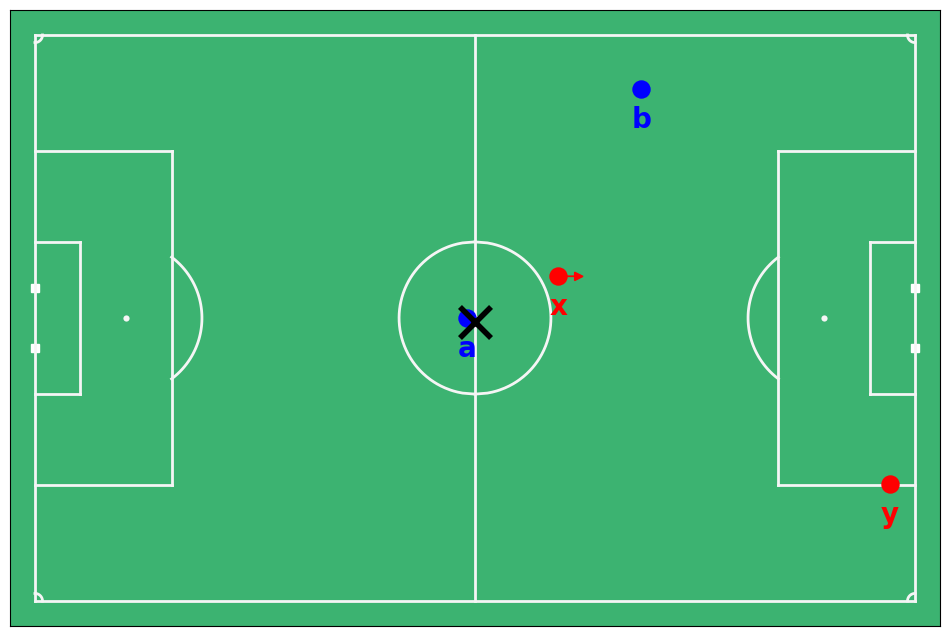

In [19]:
import accessible_space  # pip install accessible-space

ret = accessible_space.get_dangerous_accessible_space(
    df, tracking_frame_col="frame_id", tracking_player_col="player", tracking_team_col="team",
    ball_tracking_player_id="ball", tracking_x_col="x", tracking_y_col="y", tracking_vx_col="vx", tracking_vy_col="vy", attacking_direction_col="attacking_direction", possession_team_col="ball_possession", radial_gridsize=1, v0_min=1, v0_max=25, n_v0=70,
    return_cropped_result=True,
)
df["AS"] = ret.acc_space
df["frame_index"] = ret.frame_index
simulation_result = ret.simulation_result

print(f"Accessible space: {df['AS'].iloc[0]:.0f}m²")

# Using accessible_space, we can also plot the resulting possibility surface
plot_constellation_2d()
fig = dangerous_accessible_space.plot_expected_completion_surface(simulation_result, frame_index=df["frame_index"].iloc[0], plot_type_def="poss", plot_type_def="poss")

The blue and red spaces might remind you of space control models such as the ones using Voronoi cells. Accessible space replaces the fuzzy notions of "control" and "influence" from classic space control models with a properly defined quantity: To control space means to be able to receive a pass in that space.

Accessible space improves upon space control by incorporating an understanding of the mechanics of a pass: For example, if you look yt the top right corner of the pitch plot, you see some space that is not controlled by (= accessible to) either team - the red team cannot intercept there because Player b would arrive there earlier than any player of the red team. But the blue team also cannot receive there because [i]earlier on the trajectory of the pass[/i], the pass would already be intercepted by Player "x". His or her [b]cover shadow[/b], a popular concept used by coaches to teach pressing and positioning behaviour, naturally emerges from the model.

In [ ]:
df["DAS"] = ret.das
dangerous_result = ret.dangerous_result

print(f"Dangerous accessible space: {df['DAS'].iloc[0]:.1f}m²")

plot_constellation_2d()
fig = dangerous_accessible_space.plot_expected_completion_surface(
    dangerous_result, frame_index=df["frame_index"].iloc[0]
)